In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from pylab import rcParams
import warnings

warnings.filterwarnings('ignore')

In [2]:
data_november = pd.read_excel('/content/sales_november.xlsx')
data_desember = pd.read_excel('/content/sales_desember_2022.xlsx')
data_januari = pd.read_excel('/content/sales_januari.xlsx')
data_februari = pd.read_excel('/content/sales_februari.xlsx')
data_maret = pd.read_excel('/content/sales_maret.xlsx')
data_april = pd.read_excel('/content/sales_april.xlsx')


df = [data_november, data_desember, data_januari, data_februari, data_maret, data_april]
df = pd.concat(df)


In [3]:
df = df[['HARI DAN TANGGAL', 'Product Name', 'Variation', 'Quantity', 'SKU Unit Original Price', 'Order Amount']]
df.rename(columns=lambda x: x.replace(" ", "_").lower() if x != 'HARI DAN TANGGAL' else 'Date', inplace=True)

In [4]:
df = df.dropna()
df.isnull().sum()

Date                       0
product_name               0
variation                  0
quantity                   0
sku_unit_original_price    0
order_amount               0
dtype: int64

In [5]:
def clean_numeric_column(df, column):
    
    df[column] = df[column].str.replace(r'IDR|\.', '', regex=True)
    df[column] = pd.to_numeric(df[column])
    return df

df = clean_numeric_column(df, 'sku_unit_original_price')
df = clean_numeric_column(df, 'order_amount')

In [6]:
total_unit = []
for product in df['product_name']:
        if product == 'OWELA Eve Rosse Eau De Parfume - 3 PCS':
            total_unit.append(3.0)
        elif product == 'OWELA Eve Rosse Eau De Parfume - 5 PCS':  
            total_unit.append(5.0)
        else:           
            total_unit.append(1.0)
df['total_unit'] = total_unit

In [7]:
df['variation'].unique()

array(['BELI 1', 'BELI 2', 'BELI 3 PCS', 'BELI 1 GRATIS 1', 'BELI 5 PCS'],
      dtype=object)

In [8]:
def clean_variation(df, column):
    df[column] = df[column].str.replace('BELI 1 GRATIS 1', '2').str.replace(r'BELI|PCS|\s', '', regex=True).astype(float)
    return df

df = clean_variation(df, 'variation')
df.variation.unique()

array([1., 2., 3., 5.])

In [9]:
df['sold_items'] = df['variation'] * df['quantity'] * df['total_unit']


In [10]:
df = df.groupby(df.Date.dt.date)["sold_items"].sum().reset_index()
df = df.set_index('Date')
df.shape



(118, 1)

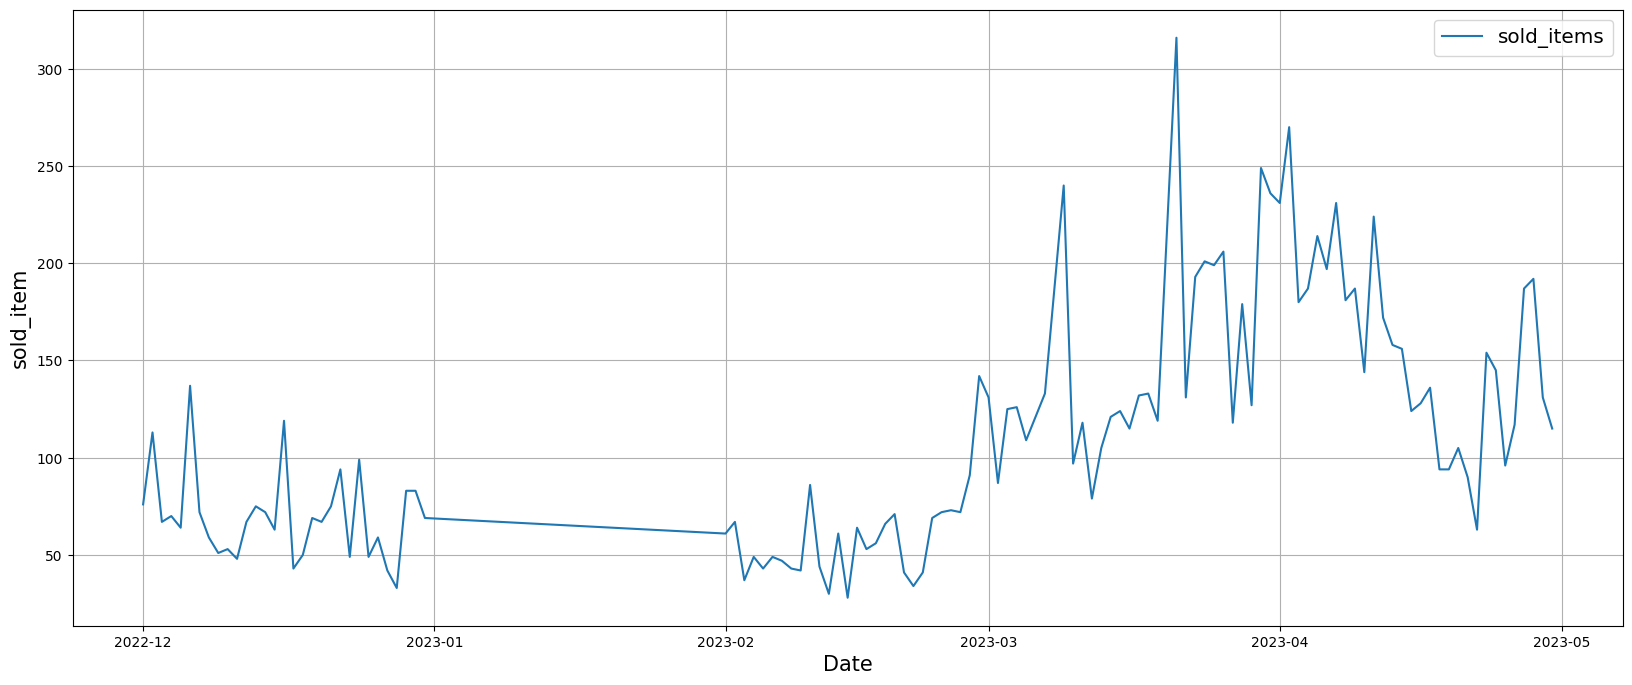

In [11]:
#Plotting the time-series
df.plot(figsize=(20,8))
plt.grid();
plt.xlabel('Date',fontsize=15)
plt.ylabel('sold_item',fontsize=15)
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.legend(fontsize="x-large")
plt.show()

In [12]:
df.head(2)

,sold_items
Date,
2022-12-01,76.0
2022-12-02,113.0


In [13]:
df.shape

(118, 1)

In [14]:
train, test = df[:77], df[77:]

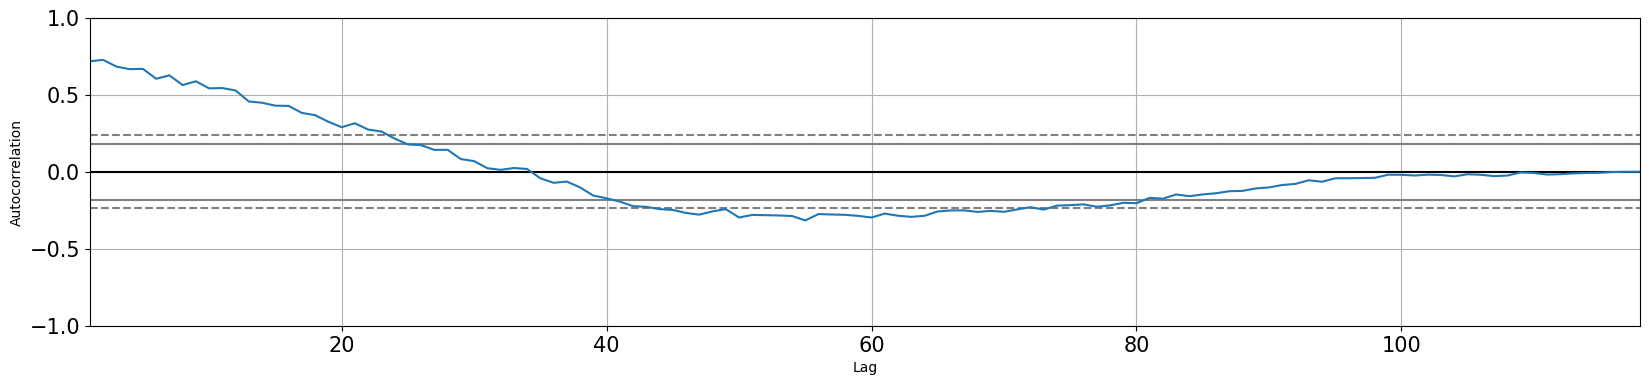

In [15]:
plt.figure(figsize=(20,4))
pd.plotting.autocorrelation_plot(df);

In [16]:
first_diff=df.diff()[1:]
# first_diff

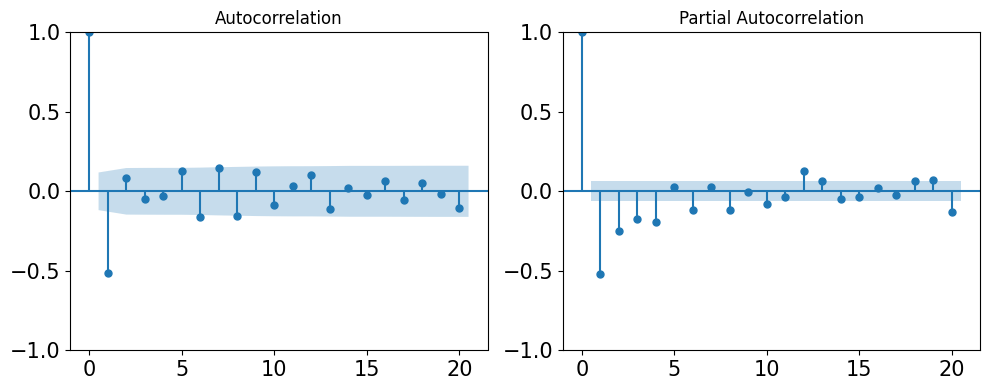

In [17]:
import statsmodels.tsa.api as smt
fig,axes=plt.subplots(1,2,sharex=False,sharey=False)
fig.set_figwidth(10)
fig.set_figheight(4)
smt.graphics.plot_acf(first_diff, lags=20, ax=axes[0], alpha=0.2) # Autocorelation
smt.graphics.plot_pacf(first_diff, lags=20, ax=axes[1], alpha=0.5) # Partial-Autocorelation
plt.tight_layout()

In [18]:
train.shape

(77, 1)

In [19]:
train_len=len(train)
train_len

naive=test.copy()
naive['naive_forecast']=train['sold_items'][train_len-1]
# naive

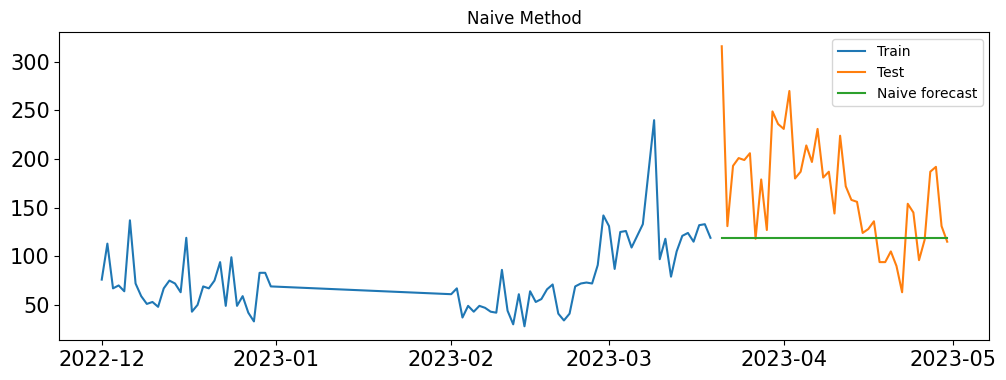

In [20]:
plt.figure(figsize=(12,4))
plt.plot(train['sold_items'], label='Train')
plt.plot(test['sold_items'], label='Test')
plt.plot(naive['naive_forecast'], label='Naive forecast')
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.legend()
plt.title('Naive Method');

In [21]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['sold_items'], naive['naive_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['sold_items']-naive['naive_forecast'])/test['sold_items'])*100,2)

results = pd.DataFrame({'Method':['Naive method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,72.4,30.76


SES-error ga ada prediksi 

In [22]:
warnings.filterwarnings('ignore')
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(train['sold_items'])
model_fit = model.fit(optimized=True)
model_fit.params
simp_expo= test.copy()
simp_expo['simp_expo_forecast'] = model_fit.forecast(len(test))

In [23]:
model_fit.params

{'smoothing_level': 0.2740113243842169,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 81.89682546143382,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

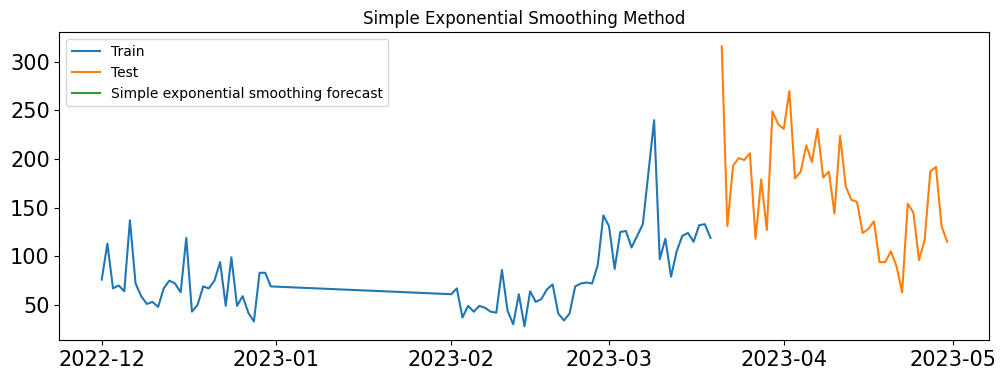

In [24]:
plt.figure(figsize=(12,4))
plt.plot(train['sold_items'], label='Train')
plt.plot(test['sold_items'], label='Test')
plt.plot(simp_expo['simp_expo_forecast'], label='Simple exponential smoothing forecast')
plt.legend()
plt.title('Simple Exponential Smoothing Method');

holt's method

In [25]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.asarray(train['sold_items']) ,seasonal_periods=12 ,trend='additive', seasonal=None)
model_fit = model.fit(optimized=True)
print(model_fit.params)
holt_trend = test.copy()
holt_trend['holt_trend_forecast'] = model_fit.forecast(len(test))


{'smoothing_level': 0.2633926529895339, 'smoothing_trend': 0.0, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 79.37900820553917, 'initial_trend': 0.5862273503257088, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


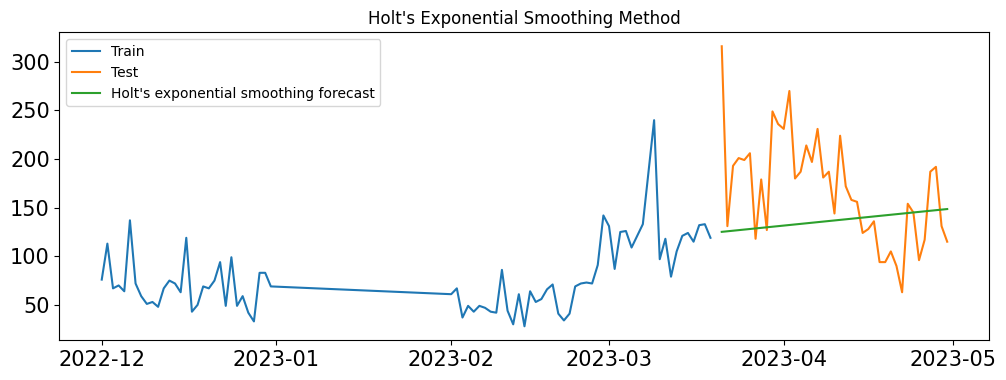

In [26]:
plt.figure(figsize=(12,4))
plt.plot( train['sold_items'], label='Train')
plt.plot(test['sold_items'], label='Test')
plt.plot(holt_trend['holt_trend_forecast'], label='Holt\'s exponential smoothing forecast')
plt.legend()
plt.title('Holt\'s Exponential Smoothing Method');

In [27]:
rmse = np.sqrt(mean_squared_error(test['sold_items'], holt_trend['holt_trend_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['sold_items']-holt_trend['holt_trend_forecast'])/test['sold_items'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt\'s exponential smoothing method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,72.40,30.76
0,Holt's exponential smoothing method,65.71,30.74


In [28]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 45.3 MB/s eta 0:00:00


In [29]:
import pmdarima as pm

def arimamodel(timeseries):
    automodel = pm.auto_arima(timeseries,
                             start_p=1,
                             start_q=1,
                             test='adf',
                             seasonal=True,
                             trace=True,
                             stepwise=False)
    return automodel

In [30]:
from statsmodels.tsa.arima.model import ARIMA
automodel=ARIMA(test,order=(0,1,1))
automodel=automodel.fit()
automodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             sold_items   No. Observations:                   41
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -210.157
Date:                Mon, 22 May 2023   AIC                            424.313
Time:                        02:53:49   BIC                            427.691
Sample:                    03-21-2023   HQIC                           425.534
                         - 04-30-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6717      0.144     -4.680      0.000      -0.953      -0.390
sigma2      2113.9478    452.904      4.668      0.000    1226.273    3001.623
===================================================================================
Ljung-Box (L1) (Q):                   0.39   Jarque-Bera (JB):                 3.24
Prob(Q):                              0.53   Prob(JB):                         0.20
Heteroskedasticity (H):               0.42   Skew:                            -0.25
Prob(H) (two-sided):                  0.13   Kurtosis:                         4.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
prediction_arima = automodel.predict(n_periodes=test.shape[0])
# prediction_arima 

In [32]:
prediction_arima['prediction_arima'] = automodel.predict(n_periodes=test.shape[0])
# prediction_arima['prediction_arima']

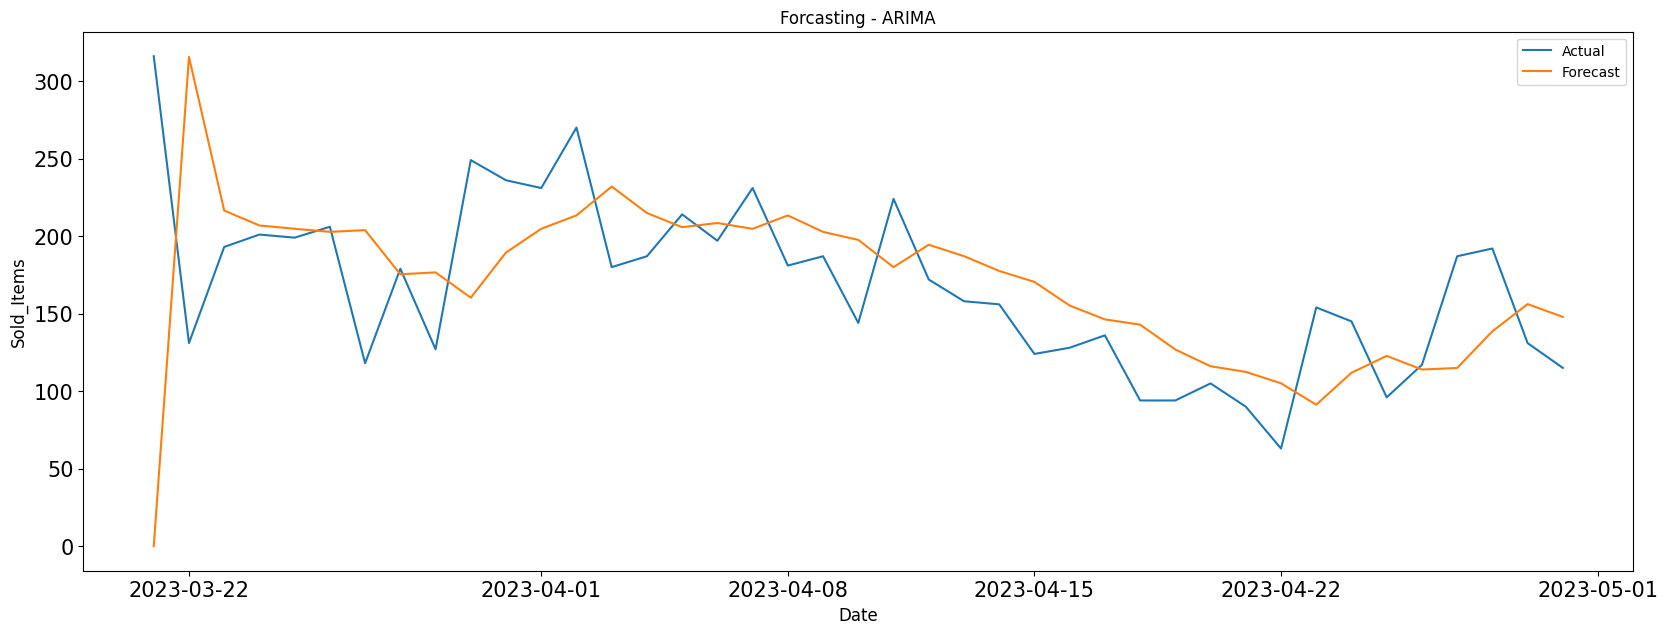

In [33]:
plt.figure(figsize=(20,7))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, prediction_arima['prediction_arima'], label='Forecast')
plt.title('Forcasting - ARIMA')
plt.xlabel('Date')
plt.ylabel('Sold_Items')
plt.legend()
plt.show()

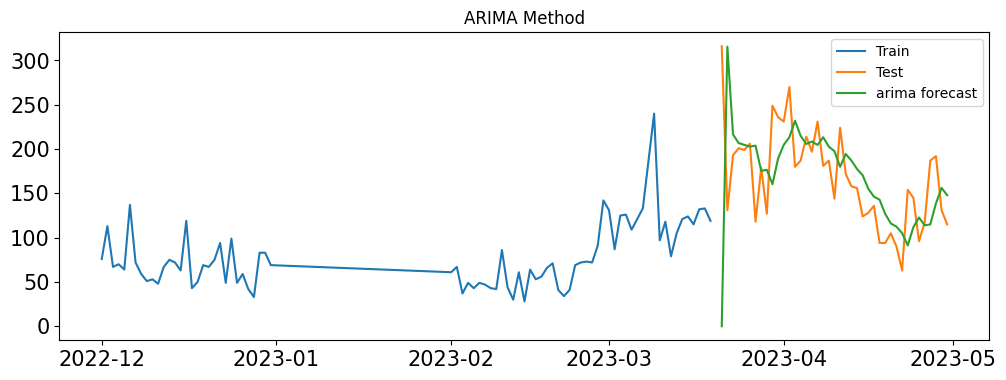

In [34]:
plt.figure(figsize=(12,4))
plt.plot( train['sold_items'], label='Train')
plt.plot(test['sold_items'], label='Test')
plt.plot(prediction_arima['prediction_arima'], label='arima forecast')
plt.legend()
plt.title('ARIMA Method');

In [35]:
rmse = np.sqrt(mean_squared_error(test['sold_items'], prediction_arima['prediction_arima'])).round(2)
mape = np.round(np.mean(np.abs(test['sold_items']-prediction_arima['prediction_arima'])/test['sold_items'])*100,2)

tempResults = pd.DataFrame({'Method':['ARIMA Method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results


,Method,RMSE,MAPE
0,Naive method,72.40,30.76
0,Holt's exponential smoothing method,65.71,30.74
0,ARIMA Method,68.96,27.29
